## Ozone Pollution: EDA, Cleaning & Analysis
Purpose: Clean and validate EPA ozone monitoring data, compute daily maximum 8‑hour ozone concentrations, analyze trends across regions and time, examine weekday/weekend effects, and produce a geospatial heatmap of high ozone concentrations.

In [4]:
import pandas as pd
ozone = pd.read_csv('/content/ozone.csv')
ozone.head()

,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,Method Code,CBSA Code,CBSA Name,County FIPS Code,County,Site Latitude,Site Longitude
0,/2024,AQS,60010007,1,0.031,ppm,29.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
1,01/02/2024,AQS,60010007,1,0.037,ppm,34.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
2,/2024,AQS,60010007,1,NaN,ppm,30.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
3,January 04/2024,AQS,60010007,1,0.026,ppm,24.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
4,January 05/2024,AQS,60010007,1,0.027,ppm,25.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217


In [5]:
ozone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29939 entries, 0 to 29938
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  29939 non-null  object 
 1   Source                                29939 non-null  object 
 2   Site ID                               29939 non-null  int64  
 3   POC                                   29939 non-null  int64  
 4   Daily Max 8-hour Ozone Concentration  28457 non-null  float64
 5   Units                                 29939 non-null  object 
 6   Daily AQI Value                       28469 non-null  float64
 7   Local Site Name                       29939 non-null  object 
 8   Daily Obs Count                       29939 non-null  int64  
 9   Percent Complete                      29939 non-null  float64
 10  Method Code                           26406 non-null  float64
 11  CBSA Code      

In [6]:
# Count of missing values in each column
ozone.isna().sum()

,0
Date,0
Source,0
Site ID,0
POC,0
Daily Max 8-hour Ozone Concentration,1482
Units,0
Daily AQI Value,1470
Local Site Name,0
Daily Obs Count,0
Percent Complete,0


In [7]:
import numpy as np

In [8]:
# Standardize column names
ozone.columns = ozone.columns.str.strip().str.lower().str.replace(' ', '_')

In [9]:
# Rename to consistent schema
ozone = ozone.rename(columns={
    'site_id': 'station_id',
    'local_site_name': 'site_name',
    'daily_max_8-hour_ozone_concentration': 'o3_ppb',
    'daily_aqi_value': 'aqi',
    'cbsa_name': 'region',
    'county': 'county',
    'site_latitude': 'latitude',
    'site_longitude': 'longitude'
})

In [10]:
ozone.head()

,date,source,station_id,poc,o3_ppb,units,aqi,site_name,daily_obs_count,percent_complete,method_code,cbsa_code,region,county_fips_code,county,latitude,longitude
0,/2024,AQS,60010007,1,0.031,ppm,29.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
1,01/02/2024,AQS,60010007,1,0.037,ppm,34.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
2,/2024,AQS,60010007,1,NaN,ppm,30.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
3,January 04/2024,AQS,60010007,1,0.026,ppm,24.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
4,January 05/2024,AQS,60010007,1,0.027,ppm,25.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217


In [11]:
# Parse date column
ozone['date'] = pd.to_datetime(ozone['date'], errors='coerce')

/tmp/ipython-input-2728457329.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ozone['date'] = pd.to_datetime(ozone['date'], errors='coerce')


In [12]:
# Drop rows with missing ozone values
ozone = ozone.dropna(subset=['o3_ppb'])

In [13]:
# Check all units are consistent
print(ozone['units'].value_counts())

if ozone['units'].nunique() > 1:
    print("Multiple units detected - conversion needed!")
else:
    print("All units are consistent")

units
ppm    28457
Name: count, dtype: int64
All units are consistent


In [14]:
# Remove duplicates
ozone = ozone.drop_duplicates(subset=['station_id', 'date'])

In [15]:
# Identify missing metadata
missing_region = ozone['region'].isna().sum()
missing_coords = ozone[['latitude','longitude']].isna().sum()

print("Missing region entries:", missing_region)
print("Missing coordinates:", missing_coords.sum())

Missing region entries: 1589
Missing coordinates: 0


In [16]:
# Quick summary
print(ozone.describe())

                                date    station_id           poc  \
count                          23745  2.374500e+04  23745.000000   
mean   2024-07-02 00:26:41.010738944  6.037171e+07      1.000547   
min              2024-01-01 00:00:00  6.001001e+07      1.000000   
25%              2024-04-02 00:00:00  6.019500e+07      1.000000   
50%              2024-07-03 00:00:00  6.037120e+07      1.000000   
75%              2024-10-01 00:00:00  6.059500e+07      1.000000   
max              2024-12-31 00:00:00  6.067001e+07      2.000000   
std                              NaN  2.000220e+05      0.023392   

             o3_ppb           aqi  daily_obs_count  percent_complete  \
count  23745.000000  22535.000000     23745.000000      23745.000000   
mean       0.044550     46.869536        26.908697         99.402106   
min        0.001000      1.000000         1.000000          6.000000   
25%        0.035000     31.000000        17.000000        100.000000   
50%        0.042000     39.

### Key Analysis

Exploratory analysis and spatial/temporal insights:

1. Trend over time and regions

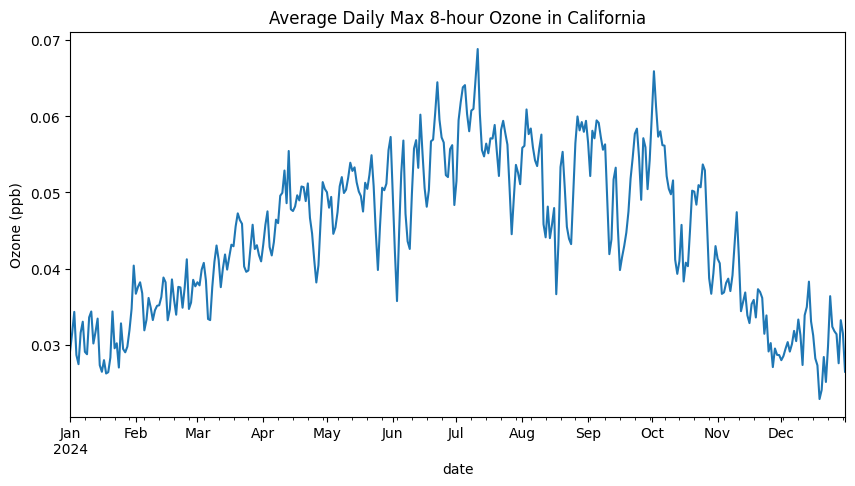

In [17]:
import matplotlib.pyplot as plt

ozone.groupby('date')['o3_ppb'].mean().plot(figsize=(10,5), title='Average Daily Max 8-hour Ozone in California')
plt.ylabel('Ozone (ppb)')
plt.show()

2. Regions with consistently high ozone

In [18]:
region_stats = (
    ozone.groupby('region')['o3_ppb']
    .agg(['mean', 'median', 'max', 'count'])
    .sort_values('mean', ascending=False)
)
print(region_stats.head(10))

                                          mean  median    max  count
region                                                              
Riverside-San Bernardino-Ontario, CA  0.052377   0.049  0.113   3133
El Centro, CA                         0.049987   0.050  0.114    985
Bakersfield, CA                       0.049072   0.047  0.096   2212
Los Angeles-Long Beach-Anaheim, CA    0.047479   0.044  0.114   3934
Merced, CA                            0.046677   0.045  0.084    285
Fresno, CA                            0.045716   0.044  0.093   1978
Hanford-Corcoran, CA                  0.045367   0.045  0.088    267
Madera, CA                            0.045188   0.044  0.082    581
Bishop, CA                            0.044873   0.044  0.076    797
Truckee-Grass Valley, CA              0.043021   0.041  0.072    288


3. Weekday vs weekend comparison

<Axes: xlabel='is_weekend', ylabel='o3_ppb'>

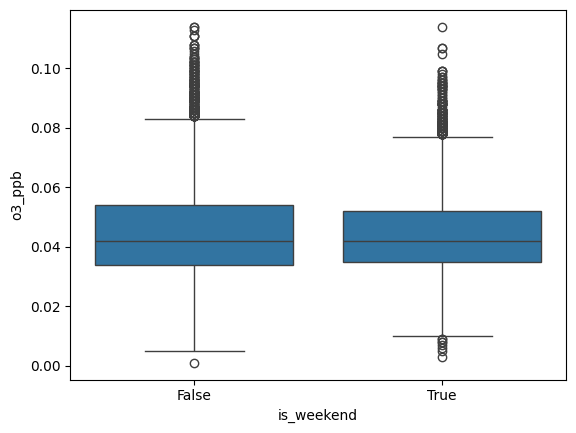

In [19]:
ozone['weekday'] = ozone['date'].dt.day_name()
ozone['is_weekend'] = ozone['weekday'].isin(['Saturday','Sunday'])

import seaborn as sns
sns.boxplot(x='is_weekend', y='o3_ppb', data=ozone)

4. Geospatial heatmap (daily averages per station)

In [20]:
import os
import folium
from folium.plugins import HeatMap

station_summary = ozone.groupby(['station_id', 'latitude', 'longitude'])['o3_ppb'].mean().reset_index()

m = folium.Map(location=[station_summary['latitude'].mean(), station_summary['longitude'].mean()], zoom_start=6)
HeatMap(station_summary[['latitude', 'longitude', 'o3_ppb']].values, radius=10).add_to(m)

#Ensure the output directory exist before saving
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)
m.save(f'{output_dir}/ozone_heatmap.html')
m

Environmental and Policy Recommendations
1. Target High-Risk Regions

Focus air-quality management and policy interventions in:

Riverside–San Bernardino–Ontario

Visalia–Porterville

El Centro

These areas exceed state and EPA’s recommended thresholds more often and should be prioritized for mitigation.

2. Public awareness

Alert residents during high-ozone days and encourage reduced traffic or outdoor activity.